BBCSports Dataset contains 5 sports categories:
- athletics, cricket, football, tennis and rugby.
- Task - Clustering News in a subcategory in BBC sports dataset.
- I have chosen to work with tennis data. The same techniques are applicable to the other sports categories datasets.


Install the Required Libraries using pip package manager in python

In [1]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pyLDAvis

Note: you may need to restart the kernel to use updated packages.


In [45]:
pip install -U sentence-transformers

  Created wheel for sentence-transformers: filename=sentence_transformers-1.0.4-py3-none-any.whl size=114312 sha256=ca02f39316afaeef106b7071d05472b789c31047ef28a27e3f466c950d1aa2a2
  Stored in directory: c:\users\jagri\appdata\local\pip\cache\wheels\36\29\9e\1d73f2751adb27f61c414d2656cef08c8353b9ad7cb7f149ef

  Created wheel for sacremoses: filename=sacremoses-0.0.44-py3-none-any.whl size=886087 sha256=9305aafcd804d22afc577300ce6736ff98b2982685f4c7e2cee11bdbd90c64a7
  Stored in directory: c:\users\jagri\appdata\local\pip\cache\wheels\8c\92\02\dad900eead4b4a0025d513fa79992095071af492c6188bd589
Successfully built sentence-transformers sacremoses


<h3> Import the required libraries </h3>

In [32]:
import os
from zipfile import ZipFile

import numpy as np
import pandas as pd

# NLTK Libraries

import nltk
import re
import string
#from textblob import Word
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

#sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import euclidean_distances

#gensim
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim.parsing.preprocessing import STOPWORDS

# libraries for visualization
# import pyLDAvis
# import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jagri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jagri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<h2> Preprocessing Texts </h2>
We need to preprocess the raw text so that we can later use it for modelling

- Converting the texts to lowercase, 
- Removing stop words
- Lemmatize each word (converting each word to its root word, e.g 'ran' -> 'run')
- Remove any punctuation, as that is not important for our analysis


In [7]:
def preprocessing(news):
    
    #Removing stopwords using NLTK
    stop = stopwords.words('english')
    
    #Making all letters lowercase and removing stopwords
    stopwords_free = " ".join(word for word in news.lower().split() if word not in stop)
    
    # Removing Punctuation, Symbols
    exclude = set(string.punctuation)
    punc_free = ''.join(ch for ch in stopwords_free if ch not in exclude)
    
    # Remove numbers
    # numbers_free = ''.join(ch for ch in punc_free.split() if ch.isalpha())
    
    #Lemmatisation
    lemmatizer = WordNetLemmatizer()
    lemmatized = " ".join([lemmatizer.lemmatize(word) for word in punc_free.split()])
    
    return lemmatized.split()

<h2> LDA </h2>

- LDA or Latent Dirichlet allocation is a technique of topic modelling in NLP. 
- It takes input the document term matrix and the dictionary (which is the corpora built from the tokenized words from our dataset) and based on no. of topics we want, it provides a topic number to each doc in our dataset. Based on the topic number what each of the doc has obtained in LDA, we can group them together. 
- In the beginning we can decide on "num_topics" randomly, later we can calculate coherence scores with various values of num_topics and select the one which has max coherence score

In [8]:
def lda(news_clean, num_topics):
  
    # Create Dictionary from the cleaned news series (in list format)     
    dictionary = corpora.Dictionary(news_clean)
    
    # Total no. of non-zero unique words in the BOW (Bag of Words) matrix
    print(dictionary.num_nnz)
    print("\nPrinting dictionary items\n", dictionary)
    
    # Create Document term frequency    
    doc_term_matrix = [dictionary.doc2bow(news) for news in news_clean]
    
    print(len(doc_term_matrix))
    
    #     print('dictionary ', dictionary)
    #     print('doc_term_matrix ', doc_term_matrix)
    
    # Creating the object for LDA model using gensim library
    LDA = gensim.models.ldamodel.LdaModel

    # Fit LDA model on the dataset
    num_topics =5
    lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=num_topics, random_state=100,
                chunksize=1000, passes=50,iterations=100)
    
    return lda_model, doc_term_matrix, dictionary
    

In [9]:
# There is bug in pyLDAvis recent version, so not calling this method at the moment
def visualization_lda(lda_model, doc_term_matrix, dictionary):
   # Visualize the topics
    #https://github.com/bmabey/pyLDAvis
    #https://speakerdeck.com/bmabey/visualizing-topic-models
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.prepare(lda_model, doc_term_matrix, dictionary)
    vis 

In [10]:
def collect_probabilities(lda_assigned_clusters):
    # get the list of probabilities
    # go to the list, capture the first list and first item in that as that contains the maximum value
    
    topics = [doc[0][0] for doc in lda_assigned_clusters]
    print(len(topics))
    return topics

<h3> Pairwise Cosine Similarity </h3>

- It is a technique to find similarity between documents using the cosine angle between 2 vectors. Or we can say dot product between tfidf and transposed tfidf vectors

In [11]:
def tfidf(myarr):
    #Extracting TF-IDF parameters
    tfidf_unigram = TfidfVectorizer(max_features=1000, lowercase=True, analyzer ='word', ngram_range=(1,1))
    tfidf_bigram = TfidfVectorizer(max_features=1000, lowercase=True, analyzer ='word', ngram_range=(1,2))
    tfidf_trigram = TfidfVectorizer(max_features=1000, lowercase=True, analyzer ='word', ngram_range=(1,3))

    news_tfidf_unigram = tfidf_unigram.fit_transform(myarr)
    news_tfidf_bigram = tfidf_bigram.fit_transform(myarr)
    news_tfidf_trigram = tfidf_bigram.fit_transform(myarr)
    
#     print(news_tfidf_trigram.shape)
    
    return news_tfidf_unigram, news_tfidf_bigram, news_tfidf_trigram

In [26]:
def most_similar(doc_id,similarity_matrix,matrix, documents_df):
    print (f'Document: {documents_df.iloc[doc_id]["news"]}')
    print ('\n')
    print ('Similar Documents:')
    if matrix=='Cosine Similarity':
        similar_ix=np.argsort(similarity_matrix[doc_id])[::-1]
    elif matrix=='Euclidean Distance':
        similar_ix=np.argsort(similarity_matrix[doc_id])
    for ix in similar_ix:
        if ix==doc_id:
            continue
        print('\n')
        print (f'Document: {documents_df.iloc[ix]["news"]}')
        print (f'{matrix} : {similarity_matrix[doc_id][ix]}')



<h3> BERT - Bidirectional Encoder Representation from Transformers</h3>


In [46]:
from sentence_transformers import SentenceTransformer

def bert(documents_cleaned):
    
    sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

    document_embeddings = sbert_model.encode(documents_cleaned)

    pairwise_similarities=cosine_similarity(document_embeddings)
    pairwise_differences=euclidean_distances(document_embeddings)

    most_similar(0,pairwise_similarities,'Cosine Similarity')
    most_similar(0,pairwise_differences,'Euclidean Distance')

<h3> KMeans </h3>

- Kmeans clustering is an unsupervised clustering technique
- Here we need to decide k prior. k is the no. of centroids around which rest of the points will accumulate
- To find the best value for k, we can plot the graph between various values of k vs the distortion (with in a luster, sum of squared errors). The point where the distortion sharply decreases is the best value for k. It is also referred as the "elbow method"
- Kmeans assume the clusters are spherical is shape
- showcased in main method, choice 2 - technique 2


In [60]:
def plot_clusters(document_df):
    # plot the 5 clusters
    clustered_docs= document_df['cluster'].value_counts()
    print(clustered_docs)
   
    clustered_docs.plot(kind='bar')
    plt.xticks(rotation=25)
    plt.show()
    

In [53]:
# calculate distortion for a range of number of cluster
def find_best_k(news_tfidf_bigram):
    distortions = []
    for i in range(1, 11):
        km = KMeans(
            n_clusters=i, init='random',
            n_init=10, max_iter=300,
            tol=1e-04, random_state=0
        )
        km.fit(news_tfidf_bigram)
        distortions.append(km.inertia_)

    # plot
    plt.plot(range(1, 11), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()

<h2> Main method </h2>

News Dataframe
                                                 news
0  Henman overcomes rival Rusedski\n \n Tim Henma...
1  Safin slumps to shock Dubai loss\n \n Marat Sa...
2  Ferrero eyes return to top form\n \n Former wo...
3  Roddick into San Jose final\n \n Andy Roddick ...
4  Federer claims Dubai crown\n \n World number o...
News Dataframe Shape
 (99, 1)

 Type 
 <class 'pandas.core.series.Series'>
documents_df['documents_cleaned']
 0     henman overcomes rival rusedski tim henman sav...
1     safin slumps shock dubai loss marat safin suff...
2     ferrero eyes return top form former world numb...
3     roddick san jose final andy roddick play cyril...
4     federer claims dubai crown world number one ro...
                            ...                        
95    agassi second round dubai fourth seed andre ag...
96    mauresmo fights back win title world number tw...
97    federer wins title rotterdam world number one ...
98    gb players warned security britain s davis cup

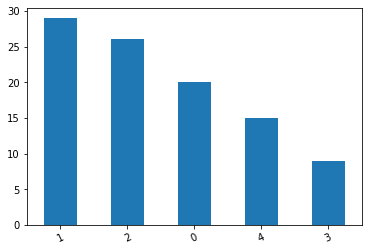

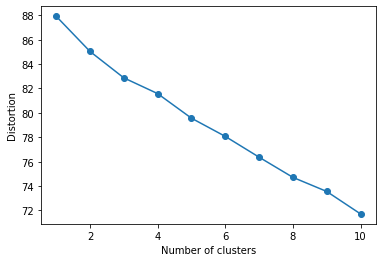

In [61]:
def main():

    # importing Dataset
    folder_path = r'C:\Users\jagri\Downloads\Projects\Altada\bbcsport-fulltext\bbcsport\tennis'
    files = os.listdir(folder_path)
    news=[]
    for text_file in files:
        file_path = folder_path + "/" +text_file
        #read contents of a file
        with open(file_path, errors='replace') as f:
            data = f.readlines()
        data = ' '.join(data)
        #append the news article and it's category to two lists
        news.append(data)
  
    #print(news)
 
    datadict ={'news':news}
    df = pd.DataFrame(datadict)
    
    # create_csv, need to run only once
    #df.to_csv('./tennis.csv')
  
    print("News Dataframe\n", df.head())
    
    # Remove any rows which have null values     
    df.dropna(axis = 0, how ='any',inplace=True)
    df.drop_duplicates(keep='first', inplace=True)
    
    print("News Dataframe Shape\n", df.shape)
        
   
    choice =2
    if choice == 1:
        
         # preprocessing()
        df['news_clean'] = df['news'].apply(preprocessing)
    
        # dataframe after cleaning
        print("\nNews Dataframe after Cleaning\n", df['news_clean'].head())
    
        num_topics =5
        lda_model, doc_term_matrix, dictionary = lda(df['news_clean'], num_topics)

        # Printing the topics which lda has produced
        print("\nPrinting the lda topics\n", lda_model.print_topics(num_topics=num_topics))

        # Visualization
        # visualization_lda(lda_model, doc_term_matrix, dictionary)

        # Find which articles were marked in which cluster
        lda_assigned_clusters = lda_model[doc_term_matrix]
        print("\nDocument Topics with probabilty scores - \n", [doc for doc in lda_assigned_clusters])

        topics = collect_probabilities(lda_assigned_clusters)
        print("\ntotal topics\n ", len(topics))

        df['topics'] =  topics

        print("\n News Dataset with the topics generated\n", df.head(30))

    if choice ==2:
        documents_df = df.copy(deep=True)
        # removing special characters and stop words from the text
        stop_words_l=stopwords.words('english')
        documents_df['documents_cleaned']=documents_df.news.apply(lambda x: " ".join(re.sub(r'[^a-zA-Z]',' ',w).lower() for w in x.split() if re.sub(r'[^a-zA-Z]',' ',w).lower() not in stop_words_l) )
        
        print("\n Type \n", type(documents_df['documents_cleaned']))
        print("documents_df['documents_cleaned']\n", documents_df['documents_cleaned'])
        
        news_tfidf_unigram, news_tfidf_bigram, news_tfidf_trigram = tfidf(documents_df.documents_cleaned)
        print("\n TfIdf Bigrams \n", news_tfidf_bigram )
        
        technique = 'kmeans'
        
        if technique == 'cosine_similarity':
            pairwise_similarities=np.dot(news_tfidf_bigram,news_tfidf_bigram.T).toarray()
            pairwise_differences=euclidean_distances(news_tfidf_bigram)

            print("\nPairwise Similarities Between Documents\n ", pairwise_similarities )

            print("\nPairwise Differences Between Documents\n ", pairwise_differences )

            most_similar(0,pairwise_similarities,'Cosine Similarity', documents_df)
     
        if technique =='kmeans':
            k=5
            model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
            model.fit(news_tfidf_bigram)

            documents_df['cluster'] =model.labels_

            print("\nAdding new colum - cluster\n", documents_df.head())

            # groupby cluster
            clusters = documents_df.groupby('cluster')

            print("\n clusters \n ", clusters)
            
#             Need to run only once
#             for cluster in clusters.groups:
#                 # create csv files based on the clusters                 
#                 f=open('cluster'+str(cluster)+'.csv', 'w')
#                 data = clusters.get_group(cluster)[['news']]
#                 f.write(data.to_csv(index_label='id'))
#                 f.close()
                
            # plot the 3 clusters
            plot_clusters(documents_df)
            
            # Use elbow method to find best K                 
            find_best_k(news_tfidf_bigram)
            
    if choice == 3:
        # giving issue with path where the sentence transformers are stored on the system
#         FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\jagri/.cache\\torch\\sentence_transformers\\sbert.net_models_bert-base-nli-mean-tokens'
        documents_df1 = df.copy(deep=True)
        stop_words_l=stopwords.words('english')
        documents_df1['documents_cleaned']=documents_df1.news.apply(lambda x: " ".join(re.sub(r'[^a-zA-Z]',' ',w).lower() for w in x.split() if re.sub(r'[^a-zA-Z]',' ',w).lower() not in stop_words_l) )
        bert(documents_df1['documents_cleaned'])
        
main()

<h2> Output - LDA</h2>
News Dataframe
                                                 news
0  Henman overcomes rival Rusedski\n \n Tim Henma...
1  Safin slumps to shock Dubai loss\n \n Marat Sa...
2  Ferrero eyes return to top form\n \n Former wo...
3  Roddick into San Jose final\n \n Andy Roddick ...
4  Federer claims Dubai crown\n \n World number o...
News Dataframe Shape
 (100, 1)

News Dataframe after Cleaning
 0    [henman, overcomes, rival, rusedski, tim, henm...
1    [safin, slump, shock, dubai, loss, marat, safi...
2    [ferrero, eye, return, top, form, former, worl...
3    [roddick, san, jose, final, andy, roddick, pla...
4    [federer, claim, dubai, crown, world, number, ...
Name: news_clean, dtype: object
13380
100

Printing the lda topics
 [(0, '0.009*"open" + 0.008*"first" + 0.007*"australian" + 0.007*"last" + 0.006*"williams" + 0.006*""i" + 0.006*"match" + 0.006*"win" + 0.005*"champion" + 0.005*"davenport"'), (1, '0.008*"win" + 0.007*"said" + 0.007*"cup" + 0.007*"beat" + 0.006*"open" + 0.006*""i" + 0.006*"davis" + 0.006*"first" + 0.006*"play" + 0.006*"two"'), (2, '0.008*"said" + 0.007*"federer" + 0.007*"first" + 0.006*"number" + 0.006*"win" + 0.006*"world" + 0.006*""i" + 0.006*"open" + 0.005*"one" + 0.005*"set"'), (3, '0.015*"roddick" + 0.011*"nadal" + 0.007*"henman" + 0.007*"first" + 0.007*"match" + 0.006*"game" + 0.006*"point" + 0.005*"break" + 0.005*"second" + 0.005*"number"'), (4, '0.011*""i" + 0.008*"said" + 0.007*"seed" + 0.006*"agassi" + 0.006*"tennis" + 0.005*"australian" + 0.005*"said." + 0.005*"like" + 0.005*"open" + 0.004*"take"')]

Document Topics with probabilty scores - 
 [[(3, 0.9960432)], [(0, 0.9922893)], [(2, 0.80661184), (3, 0.1907665)], [(3, 0.9945455)], [(3, 0.9955655)], [(0, 0.99603903)], [(4, 0.9938541)], [(2, 0.6644027), (3, 0.33064917)], [(1, 0.9944837)], [(0, 0.99519145)], [(1, 0.995147)], [(2, 0.99472106)], [(3, 0.99556756)], [(3, 0.9926963)], [(0, 0.99549866)], [(0, 0.9951912)], [(3, 0.99518585)], [(2, 0.99472106)], [(0, 0.48162407), (1, 0.5140157)], [(0, 0.9930586)], [(2, 0.99218374)], [(4, 0.99130535)], [(2, 0.9913722)], [(4, 0.99146205)], [(0, 0.99482125)], [(0, 0.3727325), (1, 0.62527865)], [(0, 0.9956522)], [(4, 0.9966351)], [(1, 0.9653658), (3, 0.032570593)], [(4, 0.99553424)], [(1, 0.9937598)], [(1, 0.99201125)], [(4, 0.9916367)], [(4, 0.99022067)], [(0, 0.9951257)], [(2, 0.99176407)], [(0, 0.99019355)], [(4, 0.9939674)], [(2, 0.7486545), (3, 0.24622393)], [(0, 0.99219877)], [(1, 0.9950552)], [(2, 0.993046)], [(1, 0.51375234), (2, 0.480347)], [(3, 0.99643254)], [(1, 0.99524146)], [(1, 0.99681574)], [(0, 0.98907244)], [(1, 0.24300115), (3, 0.75443673)], [(1, 0.99685985)], [(1, 0.99686015)], [(0, 0.9890778)], [(3, 0.996212)], [(2, 0.996688)], [(2, 0.9964537)], [(4, 0.99272037)], [(0, 0.99871504)], [(1, 0.9963775)], [(0, 0.9936806)], [(0, 0.99373096)], [(4, 0.99724275)], [(2, 0.99500847)], [(3, 0.992058)], [(1, 0.99603045)], [(2, 0.49988353), (4, 0.49426198)], [(2, 0.98984516)], [(1, 0.99679863)], [(2, 0.9931072)], [(0, 0.9962983)], [(1, 0.99657774)], [(1, 0.9965921)], [(3, 0.99901724)], [(3, 0.99433166)], [(4, 0.9975451)], [(2, 0.9934875)], [(2, 0.9980311)], [(1, 0.99488485)], [(0, 0.99462366)], [(2, 0.9908078)], [(1, 0.40165797), (3, 0.59288585)], [(1, 0.9966931)], [(4, 0.990047)], [(4, 0.99536496)], [(1, 0.9949667)], [(2, 0.99049944)], [(2, 0.990627)], [(1, 0.9903478)], [(1, 0.6319582), (3, 0.2518682), (4, 0.11361167)], [(1, 0.991389)], [(4, 0.99394596)], [(0, 0.9955842)], [(3, 0.9936009)], [(3, 0.9928726)], [(2, 0.9946145)], [(3, 0.99228996)], [(3, 0.99429035)], [(1, 0.9943855)], [(1, 0.58989453), (2, 0.40384844)], [(2, 0.99244416)], [(1, 0.9945265)], [(2, 0.9941254)]]
100

total topics
  100

 News Dataset with the topics generated
                                                  news  \
0   Henman overcomes rival Rusedski\n \n Tim Henma...   
1   Safin slumps to shock Dubai loss\n \n Marat Sa...   
2   Ferrero eyes return to top form\n \n Former wo...   
3   Roddick into San Jose final\n \n Andy Roddick ...   
4   Federer claims Dubai crown\n \n World number o...   
5   Young debut cut short by Ginepri\n \n Fifteen-...   
6   Melzer shocks Agassi\n \n Second seed Andre Ag...   
7   Federer forced to dig deep\n \n Top seed Roger...   
8   Nadal marches on in Mexico\n \n Rafael Nadal c...   
9   Hantuchova in Dubai last eight\n \n Daniela Ha...   
10  Parmar ruled out of Davis Cup tie\n \n A knee ...   
11  Davenport hits out at Wimbledon\n \n World num...   
12  Dogged Federer claims Dubai crown\n \n World n...   
13  Henman hopes ended in Dubai\n \n Third seed Ti...   
14  Mirza shocks Kuznetsova\n \n Sania Mirza conti...   
15  Hantuchova in Dubai last eight\n \n Daniela Ha...   
16  Murray to make Cup history\n \n Andrew Murray ...   
17  Davenport hits out at Wimbledon\n \n World num...   
18  Venus stunned by Farina Elia\n \n Venus Willia...   
19  Martinez sees off Vinci challenge\n \n Veteran...   
20  Serena becomes world number two\n \n Serena Wi...   
21  Hingis to make unexpected return\n \n Martina ...   
22  Clijsters set for February return\n \n Tennis ...   
23  Hewitt falls to Dent\n \n Lleyton Hewitt suffe...   
24  Angry Williams rejects criticism\n \n Serena W...   
25  Davenport dismantles young rival\n \n Top seed...   
26  Serena ends Sania Mirza's dream\n \n Sania Mir...   
27  Kuznetsova 'failed a drugs test'\n \n US Open ...   
28  What now for British tennis?\n \n Tim Henman's...   
29  Hewitt overcomes wobble in Sydney\n \n Lleyton...   

                                           news_clean  topics  
0   [henman, overcomes, rival, rusedski, tim, henm...       3  
1   [safin, slump, shock, dubai, loss, marat, safi...       0  
2   [ferrero, eye, return, top, form, former, worl...       2  
3   [roddick, san, jose, final, andy, roddick, pla...       3  
4   [federer, claim, dubai, crown, world, number, ...       3  
5   [young, debut, cut, short, ginepri, fifteen-ye...       0  
6   [melzer, shock, agassi, second, seed, andre, a...       4  
7   [federer, forced, dig, deep, top, seed, roger,...       2  
8   [nadal, march, mexico, rafael, nadal, continue...       1  
9   [hantuchova, dubai, last, eight, daniela, hant...       0  
10  [parmar, ruled, davis, cup, tie, knee, injury,...       1  
11  [davenport, hit, wimbledon, world, number, one...       2  
12  [dogged, federer, claim, dubai, crown, world, ...       3  
13  [henman, hope, ended, dubai, third, seed, tim,...       3  
14  [mirza, shock, kuznetsova, sania, mirza, conti...       0  
15  [hantuchova, dubai, last, eight, daniela, hant...       0  
16  [murray, make, cup, history, andrew, murray, b...       3  
17  [davenport, hit, wimbledon, world, number, one...       2  
18  [venus, stunned, farina, elia, venus, williams...       0  
19  [martinez, see, vinci, challenge, veteran, spa...       0  
20  [serena, becomes, world, number, two, serena, ...       2  
21  [hingis, make, unexpected, return, martina, hi...       4  
22  [clijsters, set, february, return, tennis, sta...       2  
23  [hewitt, fall, dent, lleyton, hewitt, suffered...       4  
24  [angry, williams, reject, criticism, serena, w...       0  
25  [davenport, dismantles, young, rival, top, see...       0  
26  [serena, end, sania, mirza's, dream, sania, mi...       0  
27  [kuznetsova, 'failed, drug, test', u, open, ch...       4  
28  [british, tennis?, tim, henman's, decision, qu...       1  
29  [hewitt, overcomes, wobble, sydney, lleyton, h...       4  







<h2> Output - Cosine Similarity </h2>

News Dataframe
                                                 news
0  Henman overcomes rival Rusedski\n \n Tim Henma...
1  Safin slumps to shock Dubai loss\n \n Marat Sa...
2  Ferrero eyes return to top form\n \n Former wo...
3  Roddick into San Jose final\n \n Andy Roddick ...
4  Federer claims Dubai crown\n \n World number o...
News Dataframe Shape
 (99, 1)

News Dataframe after Cleaning
 0    [henman, overcomes, rival, rusedski, tim, henm...
1    [safin, slump, shock, dubai, loss, marat, safi...
2    [ferrero, eye, return, top, form, former, worl...
3    [roddick, san, jose, final, andy, roddick, pla...
4    [federer, claim, dubai, crown, world, number, ...
Name: news_clean, dtype: object

 Type 
 <class 'pandas.core.series.Series'>
documents_df['documents_cleaned']
 0     henman overcomes rival rusedski tim henman sav...
1     safin slumps shock dubai loss marat safin suff...
2     ferrero eyes return top form former world numb...
3     roddick san jose final andy roddick play cyril...
4     federer claims dubai crown world number one ro...
                            ...                        
95    agassi second round dubai fourth seed andre ag...
96    mauresmo fights back win title world number tw...
97    federer wins title rotterdam world number one ...
98    gb players warned security britain s davis cup...
99    sharapova overcomes tough molik wimbledon cham...
Name: documents_cleaned, Length: 99, dtype: object

 TfIdf Bigrams 
   (0, 176)	0.0647608352481127
  (0, 186)	0.04150170121541258
  (0, 414)	0.12361171682897894
  (0, 923)	0.12361171682897894
  (0, 994)	0.057143250906676005
  (0, 307)	0.059307461100497665
  (0, 310)	0.053526651551663425
  (0, 751)	0.046955075363027614
  (0, 770)	0.059307461100497665
  (0, 295)	0.059307461100497665
  (0, 598)	0.031889620284348316
  (0, 97)	0.053526651551663425
  (0, 891)	0.05198191170694758
  (0, 775)	0.06180585841448947
  (0, 753)	0.03933749102159092
  (0, 615)	0.05523428222585366
  (0, 985)	0.029149315477942528
  (0, 371)	0.04590906721022673
  (0, 540)	0.1295216704962254
  (0, 895)	0.04492649358500704
  (0, 901)	0.057143250906676005
  (0, 937)	0.057143250906676005
  (0, 215)	0.057143250906676005
  (0, 88)	0.059307461100497665
  (0, 587)	0.03627035110290123
  :	:
  (98, 425)	0.0653857683200837
  (98, 611)	0.025759746913810673
  (98, 53)	0.033521537269318474
  (98, 753)	0.04805292316386609
  (98, 615)	0.06747173372987779
  (98, 642)	0.03948292426840958
  (98, 722)	0.06499667007207888
  (98, 194)	0.061776100518465
  (98, 303)	0.10973537806175547
  (98, 483)	0.11744833975629249
  (98, 759)	0.060191386183395645
  (98, 294)	0.06399566975498772
  (98, 388)	0.06747173372987779
  (98, 767)	0.09779106745592221
  (98, 969)	0.059823738935399544
  (98, 195)	0.06747173372987779
  (98, 91)	0.048895533727961106
  (98, 750)	0.12233225835776948
  (98, 772)	0.18766689101369058
  (98, 614)	0.05267811406898118
  (98, 341)	0.17803751339556284
  (98, 100)	0.11216093461410442
  (98, 60)	0.03948292426840958
  (98, 645)	0.05267811406898118
  (98, 538)	0.033521537269318474

Pairwise Similarities Between Documents
  [[1.         0.17726425 0.09607165 ... 0.18924039 0.09713642 0.12701865]
 [0.17726425 1.         0.08802551 ... 0.11395272 0.01639725 0.10636684]
 [0.09607165 0.08802551 1.         ... 0.0974896  0.10200637 0.06381039]
 ...
 [0.18924039 0.11395272 0.0974896  ... 1.         0.0397637  0.1220163 ]
 [0.09713642 0.01639725 0.10200637 ... 0.0397637  1.         0.01281086]
 [0.12701865 0.10636684 0.06381039 ... 0.1220163  0.01281086 1.        ]]

Pairwise Differences Between Documents
  [[0.         1.28275933 1.34456562 ... 1.27338887 1.34377348 1.32134882]
 [1.28275933 0.         1.35053656 ... 1.33120042 1.40257103 1.3368868 ]
 [1.34456562 1.35053656 0.         ... 1.34351062 1.3401445  1.36834909]
 ...
 [1.27338887 1.33120042 1.34351062 ... 0.         1.38581117 1.3251292 ]
 [1.34377348 1.40257103 1.3401445  ... 1.38581117 0.         1.40512572]
 [1.32134882 1.3368868  1.36834909 ... 1.3251292  1.40512572 0.        ]]
 
 
 
 Document: Henman overcomes rival Rusedski
 
 Tim Henman saved a match point before fighting back to defeat British rival Greg Rusedski 4-6 7-6 (8-6) 6-4 at the Dubai Tennis Championships on Tuesday.
 
 World number 46 Rusedski broke in the ninth game to take a tight opening set. Rusedski had match point at 6-5 in the second set tie-break after Henman double-faulted, but missed his chance and Henman rallied to clinch the set. The British number one then showed his superior strength to take the decider and earn his sixth win over Rusedski. Serve was held by both players with few alarms until the seventh game of the final set, when Rusedski's wild volley gave Henman a vital break. A furious Rusedski slammed his racket onto the ground in disgust and was warned by the umpire.
 
 Henman, seeded three, then held his serve comfortably thanks to four serve-and-volley winners to take a clear 5-3 lead. Rusedski won his service game but Henman took the first of his three match points with a service winner to secure his place in the second round at Dubai for the first time in three years. It was the first match between the pair for three years - Henman last lost to Rusedski six years ago - and lasted two hours and 40 minutes. The pair are now likely to only face each other on court as rivals - rather than as team-mates - after Henman decided to retire from Davis Cup tennis leaving Rusedski to lead the team out against Israel on 4-6 March. Henman, who now faces Russian Igor Andreev in the last 16, admitted afterwards it was difficult coming up against his compatriot on a fast surface. "You just take it point by point when you're fighting to stay in the match," he said. "I had to keep playing aggressively and competing to get a chance. "I now have to recover in time for the next match because the body doesn't recover as quick as it used to, especially after two hours and 40 minutes."



Similar Documents:


Document: Henman hopes ended in Dubai
 
 Third seed Tim Henman slumped to a straight sets defeat in his rain-interrupted Dubai Open quarter-final against Ivan Ljubicic.
 
 The Croatian eighth seed booked his place in the last four with a 7-5 6-4 victory over the British number one. Henman had looked on course to level the match after going 2-0 up in the second set, but his progress was halted as the rain intervened again. Ljubicic hit back after the break to seal a fourth straight win over Henman. Earlier in the day, Spanish fifth seed Tommy Robredo secured his semi-final place when he beat Nicolas Kiefer of Germany 6-4 6-4. Afterwards, Henman was left cursing the weather and the umpire after seven breaks for rain during the match. "It was incredibly frustrating," Henman said. "It's raining and the umpire doesn't take control. "He kept telling us to play till the end of the game. But if it's raining, you come off - the score's irrelevant. "It couldn't be more frustrating as I was very happy with my form until now. You don't expect this in the desert."

Cosine Similarity : 0.3139017219089486


Document: Classy Henman makes winning start
 
 Tim Henman opened his 2005 campaign with a 6-1 7-5 victory over Argentine David Nalbandian at the Kooyong Classic exhibition tournament on Wednesday.
 
 The British number one will next play Roger Federer at the Australian Open warm-up event on Friday. The world number one beat Gaston Gaudio 5-7 6-1 6-4, before Andre Agassi saw off Chilean Olympic gold medalist Nicolas Massu 6-1 7-6 (7-4). Andy Roddick beat Ivan Ljubicic, who replaced Paradorn Srichaphan, 6-1 6-4. Henman made an impressive start to the year, only faltering against Nalbandian when serving for the match at 5-4. But the Briton regained his composure to win the next two games for only his second win in six matches against the Argentine. "It's a great start to the year - just what I was looking for," Henman told his website. "Over the years I've found David very difficult to play against.
 
 "He returns serve very well and he's deceptively effective from the baseline, so sometimes it can be difficult to execute my gameplan well enough against him to get the right result. "Beating somebody of his stature is always good for the confidence and it bodes well at the beginning of the year." Henman also revealed the extent of the back problems he suffered in the off-season. "I'm not the most flexible and at the end of the year I was pretty exhausted and wanted to have a couple of weeks where I didn't do anything," said Henman. "When I started training again it really, really seized up. As much as I enjoyed the two weeks off I don't think it's so productive." Federer dropped a tight first set against 2004 French Open champion Gaudio, but was content with his game. "It was about getting used to the surface," he said.
 
 "The conditions are much quicker than Doha, my timing was OK, but I could have served better. "All in all I'm happy with the match, and I won it - that's a good sign. Now I have a day off and hopefully play better the next match." Agassi was delighted with victory over Massu in his first match for over two months. "I felt pretty good," said the American. "I liked the way the match played out and, maybe excluding a few second serve returns, I felt like I was doing most things pretty darn well for the first match."

Cosine Similarity : 0.28285098541105325


Document: Henman decides to quit Davis Cup
 
 Tim Henman has retired from Great Britain's Davis Cup team.
 
 The 30-year-old, who made his Davis Cup debut in 1994, is now set to fully focus on the ATP Tour and on winning his first Grand Slam event. "I've made no secret of the fact that representing Great Britain has always been a top priority for me throughout my career," Henman told his website. Captain Jeremy Bates has touted Alex Bogdanovic and Andrew Murray as possible replacements for the veteran. Henman added that he was available to help Britain in its bid for Davis Cup success, with the next tie against Israel in March . "Although I won't be playing, I would still like to make myself available to both Jeremy and the LTA in the future so that I can draw upon my experience in the hope of trying to help the British players develop their full potential," he added. "I've really enjoyed playing in front of the thousands of British fans both home and abroad and would like to thank every one of them for their unwavering support over the years." Henman leaves Davis Cup tennis with an impressive record, having won 36 of his 50 matches. Great Britain captain Jeremy Bates paid tribute to Henman's efforts over the years.
 
 "Tim has quite simply had a phenomenal Davis Cup career and it has been an absolute privilege to have captained the team with him in it," said Bates. "Tim's magnificent record speaks for itself. While it's a great loss I completely understand and respect his decision to retire from Davis Cup and focus on the Grand Slams and Tour. " "Looking to the future this decision obviously marks a watershed in British Davis Cup tennis but it is also a huge opportunity for the next generation to make their mark. "We have a host of talented players coming through and despite losing someone of Tim's calibre, I remain very optimistic about the future." Henman made his Davis Cup debut in 1994 against Romania in Manchester. He and partner Bates won their doubles rubber on the middle Saturday of the tie. Britain eventually lost the contest 3-2. Henman and Britain had little luck in Davis Cup matches until 1999 when they qualified for the World Group. Britain drew the USA and lost the tie when Greg Rusedski fell to Jim Courier in the deciding rubber. They made the final stages again, in 2002, but this time lost out to the might of Sweden.

Cosine Similarity : 0.2667973775846119


Document: Murray to make Cup history
 
 Andrew Murray will become Britain's youngest-ever Davis Cup player after it was confirmed he will play in the doubles against Israel on Saturday.
 
 The 17-year-old will play alongside fellow debutant David Sherwood against Israel's Jonathan Erlich and Andy Ram. Murray will eclipse the record set by Roger Becker back in 1952. Greg Rusedski takes Tim Henman's place as first choice in the singles, while Alex Bogdanovic will play in the second singles clash. Rusedski will take on former world number 30 Harel Levy and Bogdanovic - who has previously played in two singles rubbers against Australia - will face Noam Okun.
 
 Murray is the brightest young hope in British tennis, after winning the US Open junior title last year and the BBC Young Sports Personality of the Year. British number one Tim Henman, who announced his Davis Cup retirement earlier this year, believes Britain can win the tie in Tel Aviv. "It's going to be as really tough match. Israel have some really good players - and their doubles pair of Andy Ram and Jonathan Erlich are among the top eight in the world - but I fancy our chances," he said. But Henman urged Bogdanovic, who has had run-ins with British tennis officials in the past, to seize his chance. "Alex is a quality player - he's young but he's got to keep pushing forward. "He's got to be stronger, he's got a lot of ability but he's got to be more disciplined mentally and physically and if he does that he's got a good chance."

Cosine Similarity : 0.2405881489930324


Document: Rusedski angry over supplements
 
 Greg Rusedski has criticised the governing body of men's tennis for not releasing contamination-free supplements in time for the new season.
 
 Rusedski said: "I tried to order some but didn't receive any and I haven't got any yet. "You would think they would have been available in December as it can take two months for the body to respond. "This event comes in the hottest period of the year, so you would hope the stuff would be available for it." The British number two escaped a possible ban last year when he persuaded a tribunal that a positive doping test was the result of contaminated ATP supplements. In response, the ATP struck a deal with pharmaceutical company GlaxoSmithKline to provide contamination-free drinks and nutritional bars for the men's tour.
 
 David Higdon, Vice President of the ATP, admitted: "I agree with Greg. "I would have loved to have had these things available as soon as possible but it's a lot of work to make sure they have gone through rigorous testing. "The reality is though that the first two weeks of the tour are spread far and wide and part of the distribution agreement we had with GSK has an education component. "We weren't going to just drop these products out there without having a talk with the players about understanding how to use them.
 
 "The first chance we will get to do that is at the players meeting on the Saturday before the Australian Open." And Rusedski, who takes on Roger Federer at the Qatar Open later on Wednesday, conceded that the imminent changes will be beneficial. "The good thing is that there is now a 100% guarantee, so hopefully all this will never happen again," said Rusedski. "Hopefully after the Australian Open we won't have to discuss this any more."

Cosine Similarity : 0.23708526371927185





<h3> Kmeans Clustering - Output </h3>
Adding new colum - cluster
                                                 news  \
0  Henman overcomes rival Rusedski\n \n Tim Henma...   
1  Safin slumps to shock Dubai loss\n \n Marat Sa...   
2  Ferrero eyes return to top form\n \n Former wo...   
3  Roddick into San Jose final\n \n Andy Roddick ...   
4  Federer claims Dubai crown\n \n World number o...   

                                   documents_cleaned  cluster  
0  henman overcomes rival rusedski tim henman sav...        3  
1  safin slumps shock dubai loss marat safin suff...        3  
2  ferrero eyes return top form former world numb...        2  
3  roddick san jose final andy roddick play cyril...        1  
4  federer claims dubai crown world number one ro...        3  


- After creating separate csv files for each of the 5 clusters, took a peek at the cluster-0, found that the name of the person repeats in docs, they are considered similar by the algo
- Some docs also got repeated


clusters 
  <pandas.core.groupby.generic.DataFrameGroupBy object at 0x000001E1DB9961C8>
  
  clusters 
  <pandas.core.groupby.generic.DataFrameGroupBy object at 0x000001E1DC472988>
1    29
2    26
0    20
4    15
3     9
Name: cluster, dtype: int64
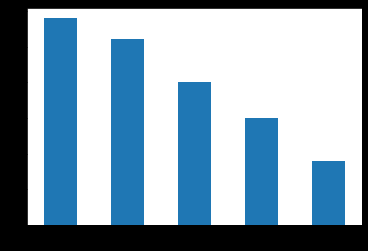


- Selecting Best K
As per the graph, there is no sharp elbow, however 4 or 5 seem like a good choice for k, because seem to comparatively sharply decrease at those points of k as compared to others

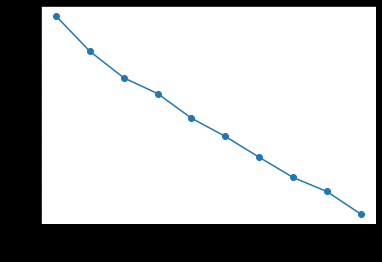